Plot the phase diagram for an Ising system on a three block chain-like SBM with external fields.

Uses data from simulations generated using *fig2-B-simulations.py*.

**Sources:**
- Customisation of heatmap tick labels based on: https://stackoverflow.com/questions/47784215/seaborn-heatmap-custom-tick-values. 

Created on: 07/12/19

In [1]:
import pandas as pd
import numpy as np
import ast
import tqdm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def from_np_array(array_string):
    '''
    Converter allows numpy arrays saved in a .csv file
    to be parsed as an array rather than being interpretted
    as a string.
    '''
    array_string = ' '.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))


f_path_block = "Data/block_level_phase_data.csv"
f_path_full_graph = "Data/full_MF_phase_data.csv"
f_path_mc = "Data/MC_phase_data.csv"


mag_data_block = pd.read_csv(f_path_block)
mag_data_MF = pd.read_csv(f_path_full_graph)
mag_data_mc = pd.read_csv(f_path_mc,converters={'magnetisation_series': from_np_array})

# Generate histograms of mean magnetisation for each $\beta$ from MC simulation data

<ipython-input-3-f3b699b3f7ad>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for beta_f in tqdm.tqdm_notebook(beta_vals) :


  0%|          | 0/20 [00:00<?, ?it/s]

<AxesSubplot:xlabel='beta_f', ylabel='M_bin'>

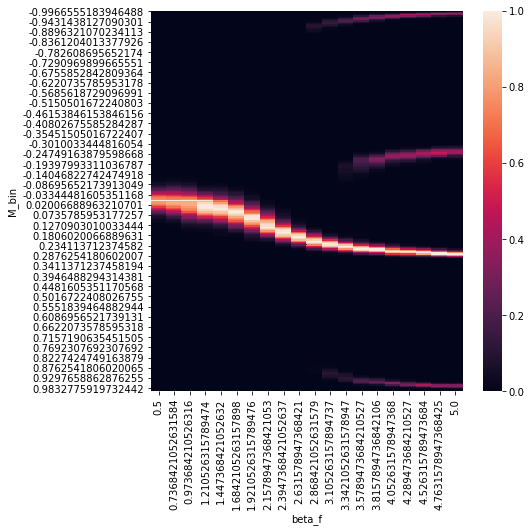

In [3]:
num_bins=300
bins = np.linspace(-1.0, 1.0, num_bins)
bin_mids = [ (bins[i]+bins[i+1])/2.0 for i in range(len(bins)-1) ]
beta_vals = sorted(list(set(list(mag_data_mc['beta_factor']))))
mc_hist_data = pd.DataFrame()

for beta_f in tqdm.tqdm_notebook(beta_vals) :
   
    df = mag_data_mc.loc[mag_data_mc['beta_factor']==beta_f]
    arrays_for_this_beta = list(df['magnetisation_series'])
    combined_arrays = np.concatenate(tuple(arrays_for_this_beta))
    hist, bins = np.histogram(combined_arrays, bins=bins)
    
    for count,b_mid in zip(hist,bin_mids) : 
        mc_hist_data=mc_hist_data.append(
        pd.DataFrame({'beta_f':[beta_f],'M_bin':[b_mid],'normed_hist_count' :[count/max(hist)] }))
    
plt.figure(2,figsize=(7,7))
piv = mc_hist_data.pivot(index='M_bin',columns='beta_f',values='normed_hist_count')
sns.heatmap(piv)

# Heatmap with mean-field and full IIM on top

In [4]:
class scatter_overlay :
    
    
    """
    To overlay scatterplots on a heatmap we need
    to scale the values to those on the axis.
    """
    
    def __init__(self,x_var,y_var,data,hm_y_ticks,hm_x_ticks,hm_x_vals,marker_style='ko',label='',alpha=0.4,markersize=5.0) :
        
        x_vals = list(data[x_var])
        y_vals = list(data[y_var])
        
        x_max = max(hm_x_vals)
        x_min = min(hm_x_vals)
        percent_through = [ (b-x_min)/(x_max-x_min) for b in x_vals ]
        x_block_width = ((hm_x_vals[1]-hm_x_vals[0])/max(hm_x_vals))*max(hm_x_ticks)
        
        scaled_x_vals = [ i*max(xticks) + x_block_width/2.0 for i in percent_through ]
        
        
        scaled_y_vals = [ hm_y_ticks[-1]*((k+1)/2.0) for k in y_vals ]
        
        plt.plot(scaled_x_vals,scaled_y_vals,marker_style,label=label,markersize=markersize,alpha=alpha)
    

<ipython-input-5-b6040a9bb65a>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  yticks = np.linspace(0, len(bins) - 1, num_yticks, dtype=np.int)
<ipython-input-5-b6040a9bb65a>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Dep

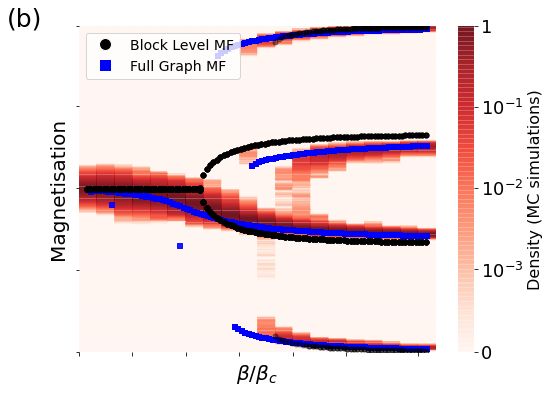

In [5]:
num_yticks = 5
yticks = np.linspace(0, len(bins) - 1, num_yticks, dtype=np.int)
yticklabels = [ round(bins[idx],1) + 0.0 for idx in yticks]

num_xticks = 7
xticks = np.linspace(0, len(beta_vals ) - 1, num_xticks, dtype=np.int)
xticklabels = [  round(beta_vals [idx],2) for idx in xticks]


plt.figure(1,figsize=(8,6))
ax = sns.heatmap(piv,cmap='Reds',yticklabels=yticklabels,
                 xticklabels=xticklabels,alpha=0.7,
                 norm=matplotlib.colors.SymLogNorm(linthresh=0.0001, linscale=0.03,vmin=-0.0, vmax=1.0))

#Set colourbar labels:
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 0.001, 0.01, 0.1, 1])
cbar.set_ticklabels(['0', '$10^{-3}$', '$10^{-2}$', '$10^{-1}$', '1'])
cbar.ax.tick_params(labelsize=18) 



full_mf_scat = scatter_overlay('beta_factor','Mean_mag_MF',
                               mag_data_MF,yticks,xticks,beta_vals,
                              marker_style='bs',alpha=0.9,label='Full Graph MF')


block_scat = scatter_overlay('beta_factor','Mean_mag_block',mag_data_block,yticks,
                             xticks,beta_vals,label='Block Level MF')




#'Proxy-Artist' for legend labels since low alpha value means things are otherwise faint:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [ Line2D([0], [0], marker='o', color='w', label='Block Level MF',
                          markerfacecolor='k', markersize=12),
                   Line2D([0], [0], marker='s', color='w', label='Full Graph MF',
                          markerfacecolor='b', markersize=12)]
plt.legend(handles=legend_elements,fontsize=14,loc='upper left')

#plt.legend()
ax.set_yticks(yticks)
ax.set_xticks(xticks)
plt.xticks(fontsize=16,rotation=0)
plt.yticks(fontsize=16,rotation=0)
plt.xlabel("$\\beta / \\beta_c$",fontsize=20)
plt.ylabel("Magnetisation",fontsize=20)
ax.collections[0].colorbar.set_label("Density (MC simulations)",fontsize=16)

plt.text(-4.0,0.1,'(b)',fontsize=25)

plt.savefig("Plots/three_block_phase_diagram.pdf",dpi=100)